In [1]:
!pip install nlp

     ---------------------------------------- 1.7/1.7 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 95.8/95.8 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 19.5/19.5 MB 1.1 MB/s eta 0:00:00


# IMPORTING LIBRARIES

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [40]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16,6))
    
    plt.subplot(1,2,1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label ='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label = 'Validation')
    plt.ylim([0.,1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label = 'Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize = (8,8))
    sp = plt.subplot(1,1,1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0,6)), labels=classes)
    plt.yticks(list(range(0,6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
print('Using tensorflow version --> ', tf.__version__)
    

Using tensorflow version -->  2.9.1


# IMPORTING DATASET

In [41]:
# Importing tweet emotion dataset
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [42]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [43]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [44]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [45]:
tweets, labels = get_tweet(train)

In [46]:
tweets[100], labels[100]

('i wont let me child cry it out because i feel that loving her and lily when she was little was going to be opportunities that only lasted for those short few months',
 'love')

# TOKENIZING THE TWEETS

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [48]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

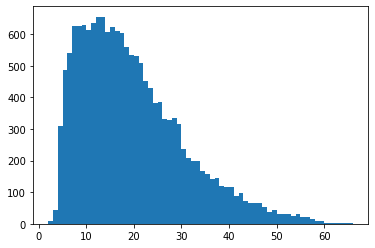

In [49]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [50]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [51]:
def get_sequences(Tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
    return padded

In [52]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [53]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [54]:
classes = set(labels)
print(classes)

{'surprise', 'joy', 'fear', 'love', 'anger', 'sadness'}


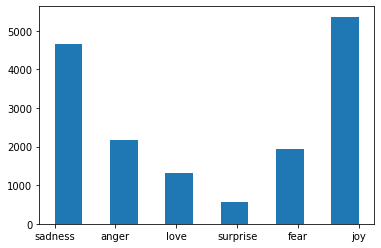

In [55]:
plt.hist(labels, bins = 11)
plt.show()

In [56]:
#CREATING DICTIONARIES
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [57]:
class_to_index

{'surprise': 0, 'joy': 1, 'fear': 2, 'love': 3, 'anger': 4, 'sadness': 5}

In [58]:
index_to_class

{0: 'surprise', 1: 'joy', 2: 'fear', 3: 'love', 4: 'anger', 5: 'sadness'}

In [59]:
names_to_id = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [60]:
train_labels = names_to_id(labels)

In [61]:
print(train_labels[0])

5


In [62]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [64]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_id(val_labels)

In [65]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [66]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)]
)

Epoch 1/20
500/500 [==============================] - 28s 41ms/step - loss: 1.3456 - accuracy: 0.4874 - val_loss: 1.0240 - val_accuracy: 0.6135
Epoch 2/20
500/500 [==============================] - 18s 37ms/step - loss: 0.7834 - accuracy: 0.7166 - val_loss: 0.6860 - val_accuracy: 0.7660
Epoch 3/20
500/500 [==============================] - 18s 37ms/step - loss: 0.4799 - accuracy: 0.8369 - val_loss: 0.5339 - val_accuracy: 0.8135
Epoch 4/20
500/500 [==============================] - 19s 37ms/step - loss: 0.3103 - accuracy: 0.8949 - val_loss: 0.4491 - val_accuracy: 0.8575
Epoch 5/20
500/500 [==============================] - 19s 37ms/step - loss: 0.2007 - accuracy: 0.9344 - val_loss: 0.4509 - val_accuracy: 0.8665
Epoch 6/20
500/500 [==============================] - 18s 37ms/step - loss: 0.1419 - accuracy: 0.9554 - val_loss: 0.4092 - val_accuracy: 0.8820
Epoch 7/20
500/500 [==============================] - 18s 37ms/step - loss: 0.1057 - accuracy: 0.9676 - val_loss: 0.4152 - val_accuracy:

# EVALUATING THE MODEL

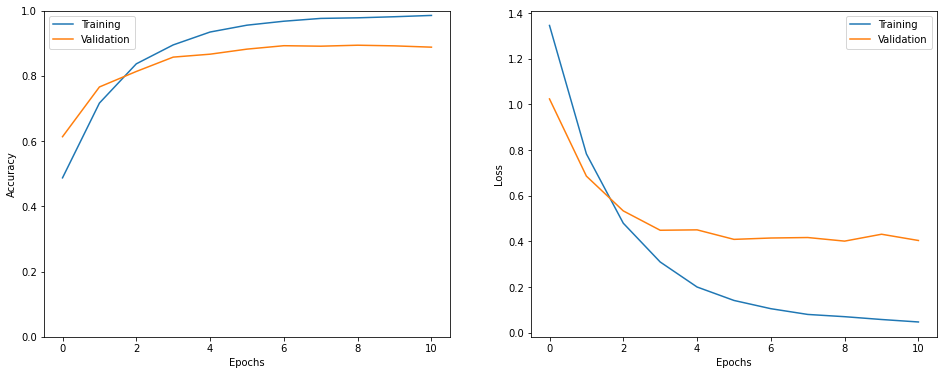

In [67]:
show_history(h)

In [70]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_id(test_labels)

In [71]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 12ms/step - loss: 0.4676 - accuracy: 0.8735


In [73]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence: ', test_tweets[i])
print('Emotion', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion', pred_class)

Sentence:  i miss not feeling exhausted after being outside in the heat for minutes
Emotion sadness
1/1 [==============================] - 0s 68ms/step
Predicted Emotion sadness
